In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import json
import csv
import seaborn as sns

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation

In [2]:
os.environ["CUAD_VISIBLE_DEVICES"]='0'
os.environ["CUAD_VISIBLE_DEVICES"]='1'

In [3]:
MMS = MinMaxScaler() # MinMaxScaler
le = LabelEncoder() # LabelEncoder
enc = OneHotEncoder() # OneHotEncoder

# 데이터 호출

In [4]:
axis = pd.read_csv('/home/master/Jibum/Motion_Show/HAR/Final/training_data.csv')

# 독립변수, 종속변수 선언

In [5]:
feature = axis.iloc[:,:-1]
label = axis['activity']

# 라벨인코딩

In [6]:
le.fit(label)
label = le.transform(label)
print(label, type(label), label.shape, le.classes_)

[0 0 0 ... 1 1 1] <class 'numpy.ndarray'> (44946,) ['sit' 'stand' 'walking']


# SMOTE 알고리즘

In [7]:
import imblearn
from collections import Counter
print(imblearn.__version__)

def count_and_plot(label):
    counter = Counter(label)
    
    for i,j in counter.items():
        print("Class = %d, n = %d (%.3f%%)" % (i, j, j/len(label)*100))
    
    plt.bar(counter.keys(), counter.values())
    plt.show()

0.8.1


Class = 0, n = 15328 (34.103%)
Class = 2, n = 12429 (27.653%)
Class = 1, n = 17189 (38.244%)


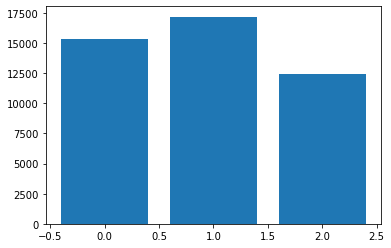

In [8]:
count_and_plot(label)

Class = 0, n = 17189 (33.333%)
Class = 2, n = 17189 (33.333%)
Class = 1, n = 17189 (33.333%)


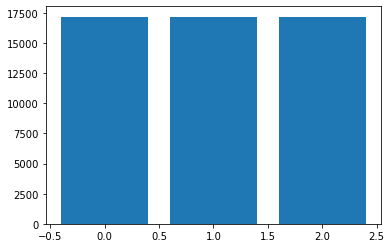

In [9]:
from imblearn.over_sampling import SMOTE
feature_resampled, label_resampled = SMOTE(random_state=0).fit_resample(feature,label)
count_and_plot(label_resampled)

In [10]:
label_resampled = np_utils.to_categorical(label_resampled)

# 스케일링 적용

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

nor = Normalizer() 
rob = RobustScaler() 
sc = StandardScaler() 


# feature_resampled = nor.fit_transform(feature_resampled)
feature_resampled = rob.fit_transform(feature_resampled)
# feature_resampled = sc.fit_transform(feature_resampled)


In [12]:
print("독립변수 : {}".format(feature_resampled.shape))
print("종속변수 : {}".format(label_resampled.shape))

독립변수 : (51567, 27)
종속변수 : (51567, 3)


# 데이터 분리

In [13]:
def split(data,target):
    x_train_all, x_test, y_train_all, y_test = train_test_split(data, target, stratify=target, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
    return x_train_all, x_train, x_val, x_test, y_train_all, y_train, y_val, y_test
    

In [14]:
x_train_all, x_train, x_val, x_test, y_train_all, y_train, y_val, y_test = split(feature_resampled,label_resampled)
print(x_train_all.shape)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train_all.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(41253, 27)
(33002, 27)
(8251, 27)
(10314, 27)
(41253, 3)
(33002, 3)
(8251, 3)
(10314, 3)


# 모델 설계

In [15]:
from tensorflow import keras

def create_model():
    model = Sequential([
        keras.layers.Dense(units=100, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(units=50, activation='relu'),
        keras.layers.Dense(units=25, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax') 
    ])
#     opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)


In [16]:
model = create_model()

history = model.fit(x_train,y_train, epochs=100, validation_data = (x_val,y_val), callbacks=[early_stop])

Epoch 1/100
1032/1032 [==============================] - 3s 2ms/step - loss: 0.1687 - accuracy: 0.9441 - val_loss: 0.0933 - val_accuracy: 0.9715
Epoch 2/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0844 - accuracy: 0.9731 - val_loss: 0.0708 - val_accuracy: 0.9784
Epoch 3/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0695 - accuracy: 0.9785 - val_loss: 0.0528 - val_accuracy: 0.9847
Epoch 4/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.0510 - val_accuracy: 0.9842
Epoch 5/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0542 - accuracy: 0.9835 - val_loss: 0.0443 - val_accuracy: 0.9878
Epoch 6/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0502 - accuracy: 0.9847 - val_loss: 0.0408 - val_accuracy: 0.9867
Epoch 7/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0472 - accuracy: 0.9852 - val_loss: 0.0553 - val_ac

Text(0, 0.5, 'Loss')

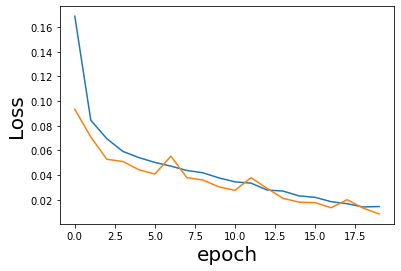

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Loss",fontsize=20)
# plt.savefig('loss.png')

Text(0, 0.5, 'Accuracy')

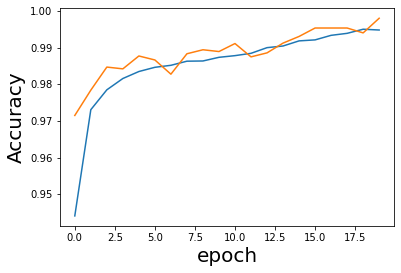

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
# plt.savefig('acc.png')

In [19]:
loss,acc = model.evaluate(x_train,y_train, verbose=2)
print("train_model acc : {}".format(100*acc))
print("train_model loss : {}".format(100*loss))

loss, acc = model.evaluate(x_test,y_test, verbose=2)
print("test_model acc : {}%".format(100*acc))
print("test_model loss : {}".format(100*loss))


1032/1032 - 1s - loss: 0.0090 - accuracy: 0.9972
train_model acc : 99.71516728401184
train_model loss : 0.9037476032972336
323/323 - 0s - loss: 0.0100 - accuracy: 0.9974
test_model acc : 99.73822236061096%
test_model loss : 1.0041349567472935


In [70]:
def create_model1():
    model1 = Sequential([
        keras.layers.Dense(units=100, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(units=50, activation='relu'),
        keras.layers.Dense(units=25, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax') 
    ])
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['Precision','accuracy','Recall'])
    
    return model1

In [71]:
model1 = create_model1()

history = model1.fit(x_train,y_train, epochs=100, validation_data = (x_val,y_val), callbacks=[early_stop])

Epoch 1/100
1032/1032 [==============================] - 3s 3ms/step - loss: 0.1191 - precision: 0.9640 - accuracy: 0.9623 - recall: 0.9599 - val_loss: 0.0695 - val_precision: 0.9779 - val_accuracy: 0.9769 - val_recall: 0.9765
Epoch 2/100
1032/1032 [==============================] - 3s 3ms/step - loss: 0.0682 - precision: 0.9797 - accuracy: 0.9795 - recall: 0.9791 - val_loss: 0.0522 - val_precision: 0.9823 - val_accuracy: 0.9823 - val_recall: 0.9821
Epoch 3/100
1032/1032 [==============================] - 3s 3ms/step - loss: 0.0535 - precision: 0.9840 - accuracy: 0.9836 - recall: 0.9830 - val_loss: 0.0480 - val_precision: 0.9867 - val_accuracy: 0.9842 - val_recall: 0.9832
Epoch 4/100
1032/1032 [==============================] - 3s 3ms/step - loss: 0.0461 - precision: 0.9860 - accuracy: 0.9854 - recall: 0.9851 - val_loss: 0.0313 - val_precision: 0.9896 - val_accuracy: 0.9887 - val_recall: 0.9881
Epoch 5/100
1032/1032 [==============================] - 3s 3ms/step - loss: 0.0356 - precis

In [72]:
print(history.history.keys())
pr=history.history['val_precision']
re=history.history['val_recall']

dict_keys(['loss', 'precision', 'accuracy', 'recall', 'val_loss', 'val_precision', 'val_accuracy', 'val_recall'])


Text(0, 0.5, 'precision')

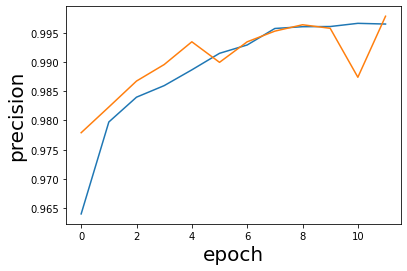

In [73]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("precision",fontsize=20)

# plt.savefig('loss.png')

Text(0, 0.5, 'recall')

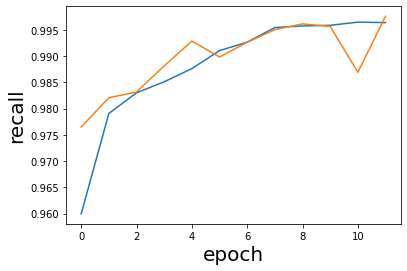

In [74]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("recall",fontsize=20)

# plt.savefig('loss.png')

Text(0, 0.5, 'Loss')

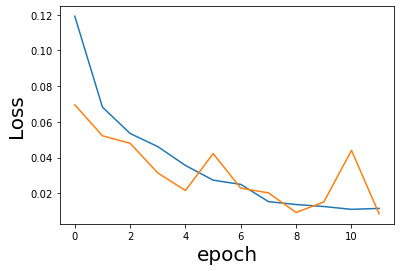

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Loss",fontsize=20)

# plt.savefig('loss.png')

Text(0, 0.5, 'Accuracy')

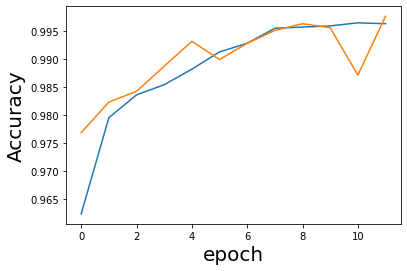

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)

# plt.savefig('acc.png')

In [77]:
loss,prec,acc,rec = model1.evaluate(x_train,y_train, verbose=2)
print("train_model acc : {}".format(100*acc))
print("train_model loss : {}".format(100*loss))

loss,prec,acc,rec = model1.evaluate(x_test,y_test, verbose=2)
print("test_model acc : {}%".format(100*acc))
print("test_model loss : {}".format(100*loss))

loss,prec,acc,rec = model1.evaluate(x_val,y_val, verbose=2)
print("val_model acc : {}%".format(100*acc))
print("val_model loss : {}".format(100*loss))

1032/1032 - 2s - loss: 0.0079 - precision: 0.9979 - accuracy: 0.9979 - recall: 0.9979
train_model acc : 99.79395270347595
train_model loss : 0.7924480363726616
323/323 - 0s - loss: 0.0075 - precision: 0.9985 - accuracy: 0.9985 - recall: 0.9984
test_model acc : 99.85456466674805%
test_model loss : 0.7503411266952753
258/258 - 0s - loss: 0.0084 - precision: 0.9978 - accuracy: 0.9977 - recall: 0.9976
val_model acc : 99.76972341537476%
val_model loss : 0.8417538367211819


In [78]:
axis = pd.read_csv('/home/master/Jibum/Motion_Show/HAR/Final/training_data.csv')

In [79]:
a = axis.iloc[:,:-1]
b = axis['activity']

In [62]:
a_train_all, a_train, a_val, a_test, b_train_all, b_train, b_val, b_test = split(a,b)
print(a_train_all.shape)
print(a_train.shape)
print(a_val.shape)
print(a_test.shape)
print(b_train_all.shape)
print(b_train.shape)
print(b_val.shape)
print(b_test.shape)

(35956, 27)
(28764, 27)
(7192, 27)
(8990, 27)
(35956,)
(28764,)
(7192,)
(8990,)


In [80]:
le.fit(b)
c = le.transform(b)
print(c, type(c), c.shape, le.classes_)

[0 0 0 ... 1 1 1] <class 'numpy.ndarray'> (44946,) ['sit' 'stand' 'walking']


In [81]:
d = np_utils.to_categorical(c)
print(d.shape)

(44946, 3)


In [82]:
loss,prec,acc,rec = model1.evaluate(a,d,verbose=2)
print("acc : {} ".format(acc*100))
print("loss : {} ".format(loss*100))

1405/1405 - 3s - loss: 19.9927 - precision: 0.3824 - accuracy: 0.3824 - recall: 0.3824
acc : 38.243669271469116 
loss : 1999.2719650268555 


In [47]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score


modelK = KerasClassifier(build_fn=create_model1, epochs=100, verbose=0)

scoring={'accuracy':make_scorer(accuracy_score),
         'precision':make_scorer(precision_score, average='micro'),
         'recall':make_scorer(recall_score, average='micro')}

results = cross_validate(modelK,a,b,cv=10,scoring=scoring)
# acc = cross_val_score(estimator=modelK, X=a,y=b, scoring='accuracy', cv=5)
# pr = cross_val_score(estimator=modelK, X=a,y=b, scoring='precision', cv=5)
# re = cross_val_score(estimator=modelK, X=a,y=b, scoring='recall', cv=5)

# scores = cross_validate(modelK,a,b,scoring=scoring,cv=5)b

In [63]:

num_folds=10
acc_val = cross_val_score(modelK,a,b,scoring='accuracy',cv=num_folds)
print("acc :"+str(round(100*acc_val.mean(),2))+'%')
pr_val = cross_val_score(modelK,a,b,scoring='precision_weighted',cv=num_folds)
print ("Precision: "+ str(round(pr_val.mean(),2))+'%')

re_val = cross_val_score(modelK,a,b,scoring='recall_weighted',cv=num_folds)
print ("Recall: "+ str(round(re_val.mean(),2))+'%')

acc :90.94%


/home/master/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.94%


/home/master/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/master/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/master/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/master/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: Un

Recall: 0.91%


In [48]:
print(results.keys())
print()
print(results)
print()
print(results.values())

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall'])

{'fit_time': array([234.87693858, 237.95594168, 238.64653683, 242.85776663,
       240.62410998, 236.73178101, 238.94122458, 234.2843821 ,
       234.94354868, 240.2621944 ]), 'score_time': array([0.19051528, 0.16285229, 0.19931173, 0.36848068, 0.17790031,
       0.19022608, 0.19682646, 0.2069056 , 0.19375229, 0.18951964]), 'test_accuracy': array([0.98420467, 0.93214683, 1.        , 0.9650723 , 0.98976641,
       0.97953281, 0.83667112, 0.81441923, 0.9670672 , 0.56853583]), 'test_precision': array([0.98420467, 0.93214683, 1.        , 0.9650723 , 0.98976641,
       0.97953281, 0.83667112, 0.81441923, 0.9670672 , 0.56853583]), 'test_recall': array([0.98420467, 0.93214683, 1.        , 0.9650723 , 0.98976641,
       0.97953281, 0.83667112, 0.81441923, 0.9670672 , 0.56853583])}

dict_values([array([234.87693858, 237.95594168, 238.64653683, 242.85776663,
       240.62410998, 236.73178101, 238.94122458, 2

In [53]:
print(results.get('test_precision'))
print(results.get('test_recall'))
print(results.get('test_accuracy'))
a = results.get('test_precision')
b = results.get('test_recall')
print()
print(a,type(a),a.shape)

[0.98420467 0.93214683 1.         0.9650723  0.98976641 0.97953281
 0.83667112 0.81441923 0.9670672  0.56853583]
[0.98420467 0.93214683 1.         0.9650723  0.98976641 0.97953281
 0.83667112 0.81441923 0.9670672  0.56853583]
[0.98420467 0.93214683 1.         0.9650723  0.98976641 0.97953281
 0.83667112 0.81441923 0.9670672  0.56853583]

[0.98420467 0.93214683 1.         0.9650723  0.98976641 0.97953281
 0.83667112 0.81441923 0.9670672  0.56853583] <class 'numpy.ndarray'> (10,)


In [55]:
print(a.mean())

0.903741639452034


In [56]:
print(b.mean())

0.903741639452034


In [ ]:
print(scores)